# Generating V3.2.1 Dataset

# Initial Setup

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark

In [2]:
# Display the status of the machine and other non-code related info
%watermark -m -g -b -h

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.14.0-23-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

Hostname: thousand-sunny-kbnt

Git hash: 8c54d4370152109cb94f9568187664bd713f1630

Git branch: main



Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [3]:
# Load `autoreload` extension
%load_ext autoreload

In [4]:
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [5]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [6]:
# Standard library imports
import pickle
from pathlib import Path
from datetime import datetime

# Third party
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%aimport hmdcpd.visualization
%aimport hmdcpd.analysis
from hmdcpd import (
    visualization,
    analysis,
)

%aimport bouncing_ball_task.bouncing_ball
%aimport bouncing_ball_task.human_bouncing_ball.dataset
%aimport bouncing_ball_task.human_bouncing_ball.catch
%aimport bouncing_ball_task.human_bouncing_ball.straight
%aimport bouncing_ball_task.human_bouncing_ball.bounce
%aimport bouncing_ball_task.human_bouncing_ball.nonwall
%aimport bouncing_ball_task.human_bouncing_ball.defaults
%aimport bouncing_ball_task.utils.pyutils
%aimport bouncing_ball_task.utils.taskutils
%aimport bouncing_ball_task.utils.htaskutils
%aimport bouncing_ball_task.utils.visualize
%aimport bouncing_ball_task.utils.gif
from bouncing_ball_task.utils import pyutils, visualize, htaskutils
from bouncing_ball_task import index
import bouncing_ball_task.human_bouncing_ball.dataset as hbb
from bouncing_ball_task.human_bouncing_ball import defaults

# Display  versions of everything
%watermark -v -iv

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

seaborn           : 0.13.2
pandas            : 2.3.1
numpy             : 2.3.1
torch             : 2.6.0
bouncing_ball_task: 0.0.0
matplotlib        : 3.10.3



In [7]:
# Figures
default_fig_size = (10, 5)
default_fig_size_smaller = (8, 5)
default_font_label = 14
default_font_title = 18
default_aspect = default_fig_size[0] / default_fig_size[1]
default_height = default_fig_size[1]
dpi = 200

# Experiment defaults
default_valid_colors={1: "red", 2: "green", 3: "blue"}

# Color Prediction Plots
color_predition_name_column_dict = {
    "Color Entered": "color_entered",
    "Next Color": "color_next",
    "Third Color": "color_after_next",
}

# Definitions

## Plotting Functions

In [8]:
## Maximum Task Sensitivity

def compute_slope_and_residuals(group, cwc):
    """Compute slope and residual variance using least squares regression."""
    X = np.vstack([group, np.ones_like(group)]).T  # Design matrix
    slope, intercept = np.linalg.lstsq(X, cwc, rcond=None)[
        0
    ]  # Solve for slope and intercept

    residuals = cwc - (slope * group + intercept)
    residual_var = residuals.var(
        ddof=1
    )  # Use variance inddstead of std to avoid redundant sqrt
    return slope, residual_var


def compute_within_subject_hz_effect_size(
    idx_time,
    cwc,
    index_high,
    index_low,
):
    """Compute within-subject standardized effect size for a single participant."""
    # Compute statistics for high and low conditions
    slope_high, residual_var_high = compute_slope_and_residuals(
        idx_time[index_high], cwc[index_high]
    )
    slope_low, residual_var_low = compute_slope_and_residuals(
        idx_time[index_low], cwc[index_low]
    )
    # Compute slope difference
    slope_diff = slope_high - slope_low

    # Compute pooled standard deviation (avoid redundant sqrt)
    sigma_pooled = np.sqrt((residual_var_high + residual_var_low) / 2)

    # Compute within-subject effect size (Cohen’s d)
    d_within = (
        slope_diff / sigma_pooled if sigma_pooled > 0 else np.nan
    )  # Avoid division by zero

    return {
        "slope_high": slope_high,
        "slope_low": slope_low,
        "slope_diff": slope_diff,
        "residual_var_high": residual_var_high,
        "residual_var_low": residual_var_low,
        "sigma_pooled": sigma_pooled,
        "d_within": d_within,
    }


def compute_within_subject_cont_effect_size(
    pccovc,
    cwc,
    index_bounce,
):
    """Compute within-subject standardized effect size for a single participant."""
    # Compute statistics for high and low conditions
    slope, residual_var = compute_slope_and_residuals(
        pccovc,
        cwc[index_bounce],
    )

    # Compute standardized effect size (Cohen’s d)
    sigma = np.sqrt(residual_var)
    d_within = (
        slope / sigma if sigma > 0 else np.nan
    )  # Avoid division by zero

    return {
        "slope": slope,
        "residual_var": residual_var,
        "d_within": d_within,
    }

def plot_effective_stats(df_data):
    # Create the subplots
    palette = visualization.get_color_palette(
        ["Low", "High"],
        (("Blues", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_trial = visualization.get_color_palette(
        ["Catch", "Straight", "Nonwall", "Bounce"],
        (("Greens", 1), ("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_contingency = visualization.get_color_palette(
        ["Low", "Medium", "High"],
        (("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )

    plot_params = [
        [
            (
                "PCCNVC_effective_ps",
                "Observed Hazard Rates",
                "Effective Hazard Rate Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": True,
                    "palette": palette,
                    "multiple": "stack",
                    "bins": 10,
                }
            ),
            (
                "PCCNVC_effective_observable_ps",
                "Observed Hazard Rates",
                "Observable Effective Hazard Rate Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": True,
                    "palette": palette,
                    "bins": 10,
                    "multiple": "stack",
                }
            ),
            (
                "PCCOVC_effective",
                "Observed Trial Contingency",
                "Effective Contingency Bins",
                {
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": True,
                    "multiple": "stack",
                },
            ),
            # (
            #     "PVC_effective",
            #     "Observed Trial Random Bounce",
            #     "Effective Random Bounce Bins",
            #     {
            #         "hue": "trial",
            #         "palette": palette_trial,
            #         "legend": True,
            #         "multiple": "stack",
            #     },
            # ),
            (
                "length",
                "Distribution of Video Lengths",
                "Video Length Bins",
                {
                    "hue": "trial",
                    "legend": True,
                    "palette": palette_trial,
                    "multiple": "stack",
                }
            ),
        ],
        [
            (
                "Color Change Random",
                "Number of Random Color Changes",
                "Random Color Change Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": False,
                    "discrete": True,
                    "palette": palette,
                    "multiple": "stack",
                }
            ),
            (
                "Color Change Random observable",
                "Number of Random Color Changes",
                "Observable Random Color Change Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": False,
                    "discrete": True,
                    "palette": palette,
                    "multiple": "stack",
                }
            ),
            (
                "Color Change Bounce",
                "Number of Bounce Color Changes",
                "Bounce Color Changes",
                {
                    "discrete": True,
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": False,
                    "multiple": "stack",
                }
            ),
            # (
            #     "Random Bounces",
            #     "Number of Random Bounces",
            #     "Number of Random Bounces",
            #     {
            #         "discrete": True,
            #         "hue": "trial",
            #         "palette": palette_trial,
            #         "legend": False,
            #         "multiple": "stack",
            #     }
            # ),
            (
                "Bounces",
                "Number of Wall Bounces",
                "Number of Wall Bounces",
                {
                    "discrete": True,
                    "hue": "trial",
                    "palette": palette_trial,
                    "legend": True,
                    "multiple": "stack",
                }
            ),
        ],
    ]

    rows = 2
    fig, axes = plt.subplots(
        rows,
        len(plot_params[0]),
        figsize=(len(plot_params[0])*4, rows*4),
    )

    for i, row_plots in enumerate(plot_params):
        for j, (col, title, xlabel, plot_dict) in enumerate(row_plots):
            ax = axes[i, j]
            sns.histplot(
                df_data,
                x=col,
                ax=ax,
                **plot_dict,
            )
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            if j != 0:
                ax.set_ylabel(None)

    plt.suptitle(f"Task Statstics for {len(df_data)} Videos")
    plt.tight_layout()

## Pipeline Function

In [9]:
def generate_dataset(
    human_dataset_parameters,
    task_parameters,
    seed=None,
    estimate_mult=100,
    hz_effective=None,
    plot=True,
):
    # Seed
    seed = pyutils.set_global_seed(seed)
    task_parameters["seed"] = human_dataset_parameters["seed"] = seed
    print(f"Dataset Seed: {seed}")

    task, samples, model_samples, targets, df_data, dict_metadata = hbb.generate_video_dataset(
        human_dataset_parameters,
        task_parameters,
        hbb.dict_trial_type_generation_funcs,
        shuffle=False,
        estimate_mult=estimate_mult,
        hz_effective=hz_effective,
    )

    dict_metadata["name"] = name_dataset = htaskutils.generate_dataset_name(
        defaults.name_dataset,
        seed=dict_metadata["seed"],
    )
    print(f"Dataset name: {name_dataset}")

    if not (variable_length := human_dataset_parameters["variable_length"]):
        try:
            samples = torch.from_numpy(samples)
            targets = torch.from_numpy(targets)
        except TypeError:
            pass
        batch_size, timesteps, _ = samples.shape

    else:
        try:
            samples = [torch.from_numpy(sample) for sample in samples]
            targets = [torch.from_numpy(target) for target in targets]
        except TypeError:
            pass

        batch_size = len(samples)
        timesteps = torch.from_numpy(df_data.length.values)

    task_parameters["batch_size"] = batch_size
    dict_metadata["task_parameters"] = task_parameters
    dict_metadata["human_dataset_parameters"] = human_dataset_parameters

    pccnvc_effective = torch.from_numpy(df_data.PCCNVC_effective.to_numpy())
    pccovc_effective = torch.from_numpy(df_data.PCCOVC_effective.to_numpy())
    pvc_effective = torch.from_numpy(df_data.PVC_effective.to_numpy())
    correct_response = torch.from_numpy(df_data.correct_response.to_numpy()) - 1
    color_entered = torch.from_numpy(df_data.color_entered.to_numpy()) - 1
    color_after_next = torch.from_numpy(df_data.color_after_next.to_numpy()) - 1
    color_entered_rgb = torch.eye(3)[color_entered]

    last_visible_idx = torch.from_numpy(df_data.last_visible_color_idx_inner.values)
    timesteps_to_end = torch.from_numpy(df_data.length.values) - last_visible_idx

    if not variable_length:
        timesteps_idx = torch.arange(timesteps).repeat((batch_size, 1))
        mask_last_timesteps = timesteps_idx > last_visible_idx.unsqueeze(-1)
        bounce_last_timesteps = (mask_last_timesteps & targets[:, :, 5:7].any(dim=-1)).any(dim=-1)
    else:
        timesteps_idx = [torch.arange(t) for t in timesteps]
        mask_last_timesteps = [timesteps_idx[i] > last_visible_idx[i] for i in range(batch_size)]
        bounce_last_timesteps = torch.stack([
            (mask & target[:, 5:7].any(dim=-1)).any(dim=-1)
            for mask, target in zip(mask_last_timesteps, targets)
        ])

    # Subtract a timestep for the bounce since random changes cannot happen
    timesteps_random_change = timesteps_to_end - bounce_last_timesteps.int()

    # Transition matrix for random changes
    third = torch.zeros_like(pccnvc_effective)
    T_ccr = torch.stack(
        [
            torch.stack([1 - pccnvc_effective, pccnvc_effective, third], dim=-1),
            torch.stack([third, 1 - pccnvc_effective, pccnvc_effective], dim=-1),
            torch.stack([pccnvc_effective, third, 1 - pccnvc_effective], dim=-1),
        ],
        dim=1,
    )

    max_exponent = int(timesteps_random_change.max().item())

    # Precompute all powers from 0 to max_exponent.
    # For k = 0, use the identity matrix.
    I = torch.eye(T_ccr.shape[-1])
    T_ccr_powers = []
    for k in range(max_exponent + 1):
        if k == 0:
            # Expand identity to shape [B, 3, 3]
            T_ccr_powers.append(I.unsqueeze(0).expand(batch_size, -1, -1))
        else:
            T_ccr_powers.append(torch.matrix_power(T_ccr, k))
    # Stack into a tensor of shape [max_exponent+1, B, 3, 3]
    T_ccr_powers = torch.stack(T_ccr_powers, dim=0)
    T_ccr_exp = T_ccr_powers[timesteps_random_change, torch.arange(batch_size), :, :].float()

    # Apply random color transitions
    belief_oracle = torch.bmm(color_entered_rgb.unsqueeze(1), T_ccr_exp).squeeze(1)

    # Transition for bounces
    T_ccb = torch.stack(
        [
            torch.stack([1 - pccovc_effective, pccovc_effective, third], dim=-1),
            torch.stack([third, 1 - pccovc_effective, pccovc_effective], dim=-1),
            torch.stack([pccovc_effective, third, 1 - pccovc_effective], dim=-1),
        ],
        dim=1,
    ).float()
    belief_oracle[bounce_last_timesteps] = torch.bmm(
        belief_oracle[bounce_last_timesteps].unsqueeze(1),
        T_ccb[bounce_last_timesteps],
    ).squeeze(1)

    labels_coded = torch.where(color_entered == correct_response, -1, 1)
    # labels_coded[labels_coded == 1] = torch.where(
    #     correct_response[labels_coded == 1] == color_after_next[labels_coded == 1],
    #     2,
    #     1,
    # )
    labels_prob = belief_oracle[torch.arange(batch_size), correct_response]
    labels_weighted = (labels_coded * labels_prob).numpy()
    df_data["cwl"] = labels_weighted

    df_straight = df_data[df_data["trial"] == "Straight"]
    df_bounce = df_data[df_data["trial"] == "Bounce"]
    df_nonwall = df_data[df_data["trial"] == "Nonwall"]
    df_bounce_comb = df_data[df_data["trial"].isin(["Bounce", "Nonwall"])]

    effect_hz_ico = compute_within_subject_hz_effect_size(
        df_data.idx_time.to_numpy(),
        labels_weighted,
        df_straight[df_straight["Hazard Rate"] == "High"].index,
        df_straight[df_straight["Hazard Rate"] == "Low"].index,
    )

    effect_cont_ico_bounce = compute_within_subject_cont_effect_size(
        df_bounce.PCCOVC.to_numpy(),
        labels_weighted,
        df_bounce.index,
    )

    effect_cont_ico_nonwall = compute_within_subject_cont_effect_size(
        df_nonwall.PCCOVC.to_numpy(),
        labels_weighted,
        df_nonwall.index,
    )

    effect_cont_ico = compute_within_subject_cont_effect_size(
        df_bounce_comb.PCCOVC.to_numpy(),
        labels_weighted,
        df_bounce_comb.index,
    )
    print(f"\nLabels Straight - Hz Slope Diff: {effect_hz_ico['slope_diff']:.3f}")
    print(f"  Labels Straight - High Hz Slope: {effect_hz_ico['slope_high']:.3f}")
    print(f"  Labels Straight - Low Hz Slope: {effect_hz_ico['slope_low']:.3f}")
    print(f"\nLabels Bounce + Nonwall - Cont Slope: {effect_cont_ico['slope']:.3f}")
    print(f"  Labels Bounce - Cont Slope: {effect_cont_ico_bounce['slope']:.3f}")
    print(f"  Labels Nonwall - Cont Slope: {effect_cont_ico_nonwall['slope']:.3f}")

    percent_no_change = (color_entered == correct_response).float().mean() * 100
    print(f"\nChange Split")
    print(f"  No Change: {percent_no_change:.1f}%")
    print(f"  Change: {100 - percent_no_change:.1f}%")

    print(f"\nTotal Wall Bounces: {df_data.Bounces.sum()}")
    print(f"Total Random Bounces: {df_data['Random Bounces'].sum()}")

    dict_hz = {}
    for hz, df_hz in df_straight.groupby("Hazard Rate"):
        dict_hz[hz] = {}
        for pos, df_pos in df_hz.groupby("idx_time"):
            dict_hz[hz][pos] = (df_pos.color_entered == df_pos.correct_response).mean()

    print(f"Low HZ -- {dict_hz['Low'][0]:.2f} -- {dict_hz['Low'][1]:.2f} -- {dict_hz['Low'][2]:.2f}")
    print(f"High HZ -- {dict_hz['High'][0]:.2f} -- {dict_hz['High'][1]:.2f} -- {dict_hz['High'][2]:.2f}")

    if plot:
        plot_effective_stats(df_data)
        ylim = (-1, 1.0)
    
        visualization.multi_plot_color_prediction_counts(
            df_straight,
            "Label Hazard Rate Sensitivity",
            hue="Hazard Rate",
            x="idx_time",
            y="cwl",
            ylabel="Confidence Weighted Choice",
            xlabel="Grayzone Position",
            ylim=ylim,
            palette_labels=["Low", "High"],
            palette_color_counts=(("Greens", 2),),
            palette_linspace_range=(0.333, 1.2),
        )
    
        visualization.multi_plot_color_prediction_counts(
            df_bounce_comb,
            "Label Contingency Sensitivity - Bounce + Nonwall Trials",
            hue="Contingency",
            x="Contingency",
            y="cwl",
            ylabel="Confidence Weighted Choice",
            ylim=ylim,
            palette_labels=['Low', 'Medium', 'High'],
            palette_color_counts=(("Reds", 3),),
            palette_linspace_range=(0.333, 1.2),
            plot_2=None,
            no_legend=True,
        )
    
        visualization.multi_plot_color_prediction_counts(
            df_bounce,
            "Label Contingency Sensitivity - Bounce Trials",
            hue="Contingency",
            x="Contingency",
            y="cwl",
            ylabel="Confidence Weighted Choice",
            ylim=ylim,
            palette_labels=['Low', 'Medium', 'High'],
            palette_color_counts=(("Reds", 3),),
            palette_linspace_range=(0.333, 1.2),
            plot_2=None,
            no_legend=True,
        )
    
        visualization.multi_plot_color_prediction_counts(
            df_nonwall,
            "Label Contingency Sensitivity - Nonwall Bounce Trials",
            hue="Contingency",
            x="Contingency",
            y="cwl",
            ylabel="Confidence Weighted Choice",
            ylim=ylim,
            palette_labels=['Low', 'Medium', 'High'],
            palette_color_counts=(("Reds", 3),),
            palette_linspace_range=(0.333, 1.2),
            plot_2=None,
            no_legend=True,
        )

    return task, samples, model_samples, targets, df_data, dict_metadata

# Generating the Dataset

In [31]:
list_hz_effective = [
    {'Low': np.float64(0.005312872889029737), 'High': np.float64(0.037649329537056374)},
    {'Low': np.float64(0.0053451518735307905), 'High': np.float64(0.037582385292305974)},
    {'Low': np.float64(0.005358737955024098), 'High': np.float64(0.03763879190660818)},
    {'Low': np.float64(0.00540488461452331), 'High': np.float64(0.03757887455932383)},
    {'Low': np.float64(0.005283875611806763), 'High': np.float64(0.03759036334157688)},
    {'Low': np.float64(0.005283214648479053), 'High': np.float64(0.0376226489465634)},
]
hz_effective = {
    cond: np.mean([val[cond] for val in list_hz_effective])
    for cond in ["Low", "High"]
}
hz_effective

{'Low': np.float64(0.005331456265398958),
 'High': np.float64(0.037610398930572435)}

2025-07-12 16:00:08.950 | DEBUG    | bouncing_ball_task.bouncing_ball:color_mask_mode:546 - Running color_mask_mode setter
2025-07-12 16:00:08.951 | DEBUG    | bouncing_ball_task.bouncing_ball:transitioning_change_mode:524 - Running transitioning_change_mode setter
2025-07-12 16:00:08.951 | DEBUG    | bouncing_ball_task.bouncing_ball:sequence_mode:471 - Running sequence_mode setter
2025-07-12 16:00:08.951 | DEBUG    | bouncing_ball_task.bouncing_ball:resample_change_probabilities:572 - Running resample_change_probabilities
2025-07-12 16:00:08.952 | DEBUG    | bouncing_ball_task.bouncing_ball:color_sampling:428 - Running color_sampling setter
2025-07-12 16:00:08.953 | DEBUG    | bouncing_ball_task.bouncing_ball:return_change_mode:510 - Running return_change_mode setter
2025-07-12 16:00:08.974 | DEBUG    | bouncing_ball_task.bouncing_ball:color_mask_mode:546 - Running color_mask_mode setter
2025-07-12 16:00:08.974 | DEBUG    | bouncing_ball_task.bouncing_ball:transitioning_change_mode:52

Dataset Seed: 622525130
Dataset Generation Summary
  Num Total Trials: 168 (29 min 41.8 sec)
    ball_radius:                         10
    dt:                                  0.1
    duration:                            50
    exp_scale:                           3.75
    border_tolerance_outer:              1.25
    mask_center:                         0.5
    mask_fraction:                       0.3333333333333333
    size_x:                              256
    size_y:                              256
    num_pos_x_endpoints:                 3
    num_pos_y_endpoints:                 8
    y_pos_multiplier:                    8
    pvc:                                 0.0
    num_y_velocities:                    2
    bounce_offset:                       0.4
    border_tolerance_inner:              0.1
    num_pos_x_linspace_bounce:           5
    idx_linspace_bounce:                 0
    bounce_timestep:                     5
    repeat_factor:                       3
    seed

/tmp/ipykernel_9023/2843340989.py:11: RuntimeWarning: Degrees of freedom <= 0 for slice
  residual_var = residuals.var(
/home/apra/miniconda3/envs/hmdcpd/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/apra/miniconda3/envs/hmdcpd/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_9023/1574967801.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for hz, df_hz in df_straight.groupby("Hazard Rate"):


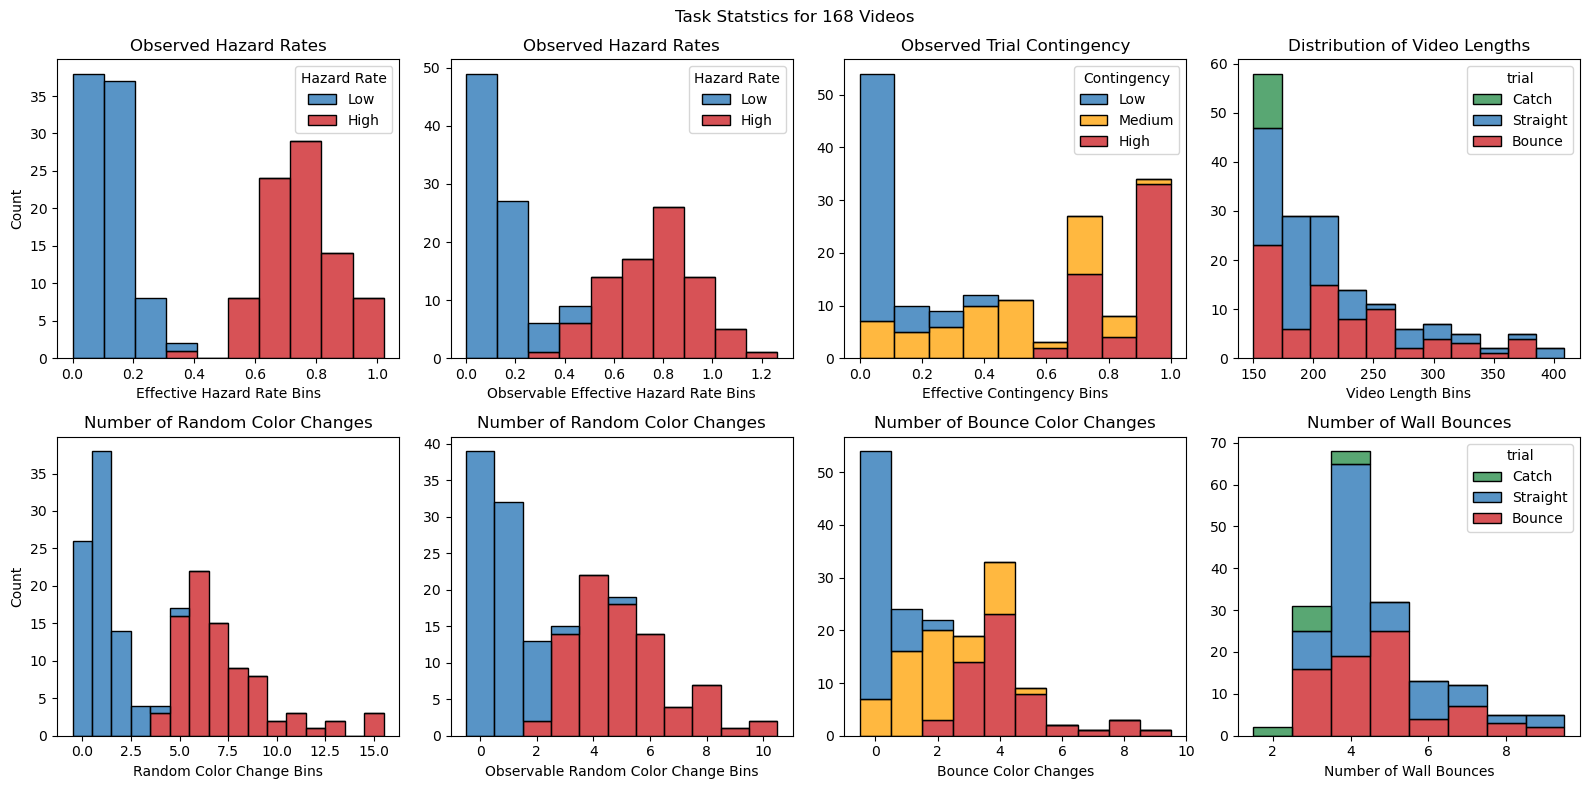

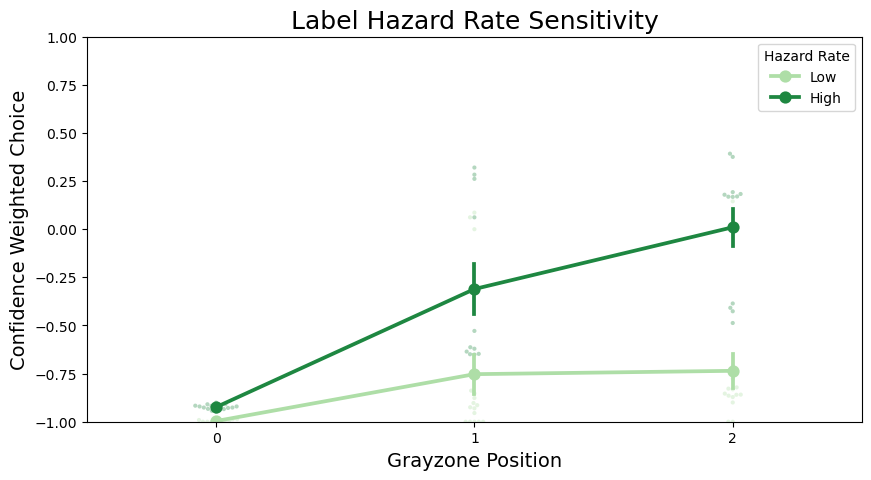

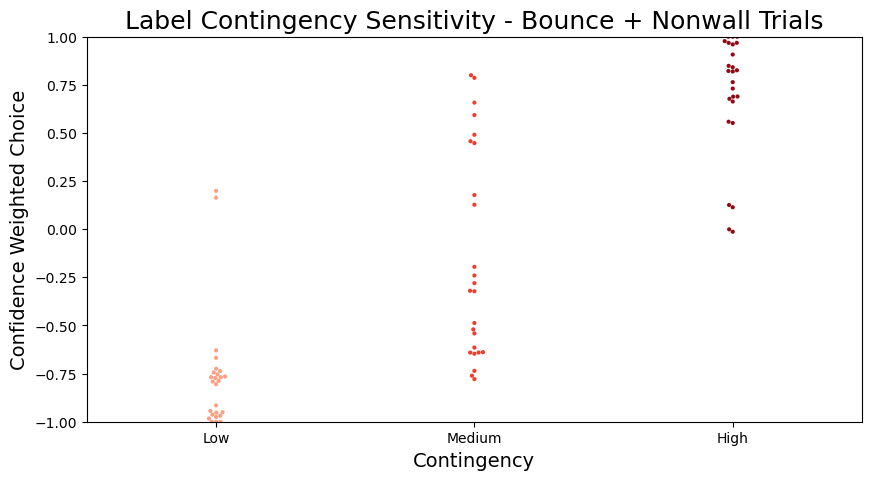

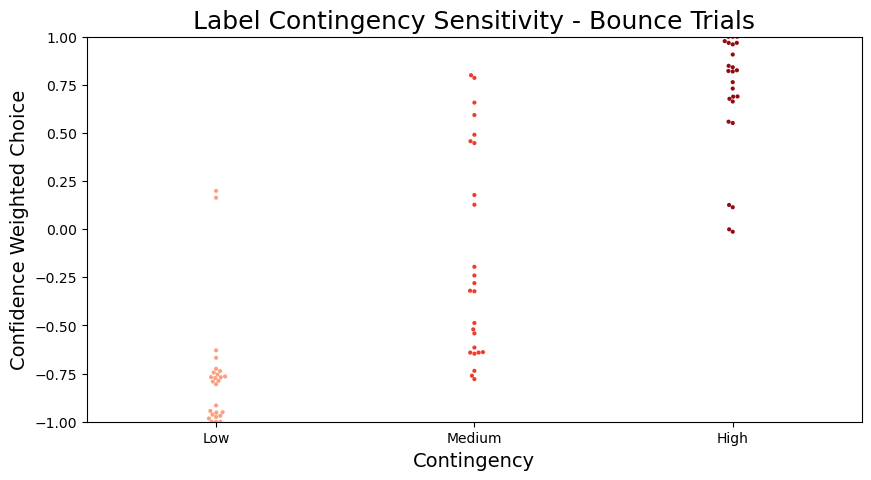

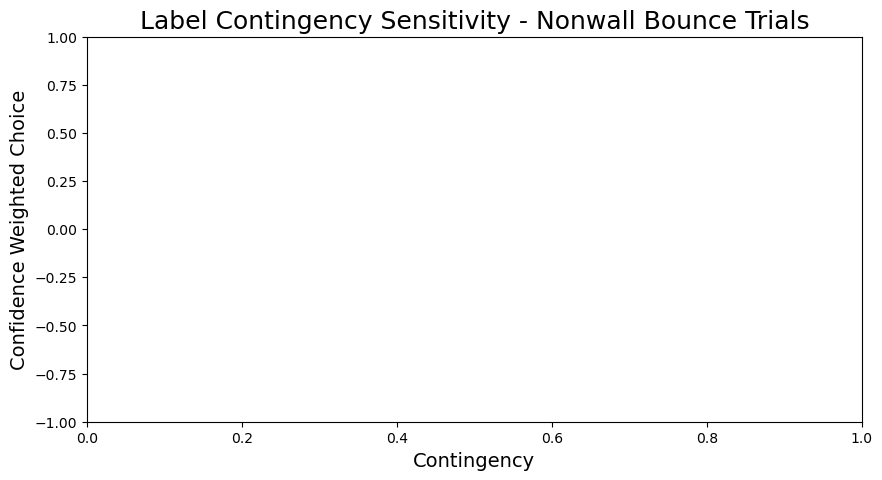

In [33]:
task_parameters = defaults.task_parameters.asdict
human_dataset_parameters = defaults.human_dataset_parameters.asdict

seed = 622525130
estimate_mult = 10
# hz_effective = None
# hz_effective = {'Low': np.float64(0.007429613209647224), 'High': np.float64(0.01762257424776564)}
human_dataset_parameters["total_dataset_length"] = 30
if not estimate_mult:
    human_dataset_parameters["total_dataset_length"] *= 100
# human_dataset_parameters["trial_type_split"] =  (0.05, -1, -1, 0)
human_dataset_parameters["trial_type_split"] =  (0.05, -1, -1, 0)


human_dataset_parameters["velocity_lower"] = 0.1
human_dataset_parameters["velocity_upper"] = 0.12
human_dataset_parameters["pvc"] = 0.0

# human_dataset_parameters["velocity_lower"] = 0.08
# human_dataset_parameters["velocity_upper"] = 2/15

human_dataset_parameters["pccnvc_lower"] = 0.00875
human_dataset_parameters["pccnvc_upper"] = 0.15
human_dataset_parameters["pccovc_lower"] = 0.05
human_dataset_parameters["pccovc_upper"] = 0.95
human_dataset_parameters["video_length_min_s"] = 7.5
human_dataset_parameters["transition_tol"] = 1
human_dataset_parameters["num_blocks"] = 10

human_dataset_parameters["border_tolerance_inner"] = 0.1
# human_dataset_parameters["total_dataset_length"] = 350
human_dataset_parameters["duration"] = 50
human_dataset_parameters["exp_scale"] = 3.75

human_dataset_parameters["trial_type_split"] =  (0.05, -1, -1, 0)
# human_dataset_parameters["min_t_color_change_after_bounce"] = 45
# human_dataset_parameters["min_t_color_change_after_random"] = 500
# human_dataset_parameters["min_t_velocity_change_after_bounce"] = 75
# human_dataset_parameters["min_t_velocity_change_after_random"] = 160

task_parameters["warmup_t_no_rand_velocity_change"] = 30
task_parameters["warmup_t_no_rand_color_change"] = 2

task_parameters["min_t_color_change_after_bounce"] = 15
task_parameters["min_t_color_change_after_random"] = 15
task_parameters["min_t_velocity_change_after_bounce"] = 30
task_parameters["min_t_velocity_change_after_random"] = 15


# # human_dataset_parameters["velocity_lower"] = 0.0975
# # human_dataset_parameters["velocity_upper"] = 0.1125
# human_dataset_parameters["velocity_lower"] = 0.05
# human_dataset_parameters["velocity_upper"] = 0.08
# human_dataset_parameters["pvc"] = 0.0

# # human_dataset_parameters["velocity_lower"] = 0.08
# # human_dataset_parameters["velocity_upper"] = 2/15

# human_dataset_parameters["pccnvc_lower"] = 0.0115
# human_dataset_parameters["pccnvc_upper"] = 0.067
# human_dataset_parameters["pccovc_lower"] = 0.1
# human_dataset_parameters["pccovc_upper"] = 0.9
# human_dataset_parameters["video_length_min_s"] = 8
# human_dataset_parameters["transition_tol"] = 1
# human_dataset_parameters["num_blocks"] = 10

# human_dataset_parameters["border_tolerance_inner"] = 0.05
# human_dataset_parameters["duration"] = 30
# human_dataset_parameters["exp_scale"] = 3.75


# # human_dataset_parameters["min_t_color_change_after_bounce"] = 45
# # human_dataset_parameters["min_t_color_change_after_random"] = 500
# # human_dataset_parameters["min_t_velocity_change_after_bounce"] = 75
# # human_dataset_parameters["min_t_velocity_change_after_random"] = 160

# task_parameters["warmup_t_no_rand_velocity_change"] = 30
# task_parameters["warmup_t_no_rand_color_change"] = 2

# task_parameters["min_t_color_change_after_bounce"] = 35
# task_parameters["min_t_color_change_after_random"] = 35
# task_parameters["min_t_velocity_change_after_bounce"] = 30
# task_parameters["min_t_velocity_change_after_random"] = 30
# task_parameters["min_t_bounce_color_change_after_random"] = 5
# task_parameters["transitioning_change_mode"] = "half"
# task_parameters["mask_fraction"] = human_dataset_parameters["mask_fraction"] = 1/3


# print(human_dataset_parameters["warmup_t_no_rand_velocity_change"])

task, samples, model_samples, targets, df_data, dict_metadata = generate_dataset(
    human_dataset_parameters,
    task_parameters,
    seed,
    estimate_mult=estimate_mult,
    hz_effective=hz_effective,
    plot=True,
)
seed = task_parameters["seed"]

# Saving the Dataset

In [34]:
print(dict_metadata["name"])
dir_base = index.dir_repo / "data/hmdcpd"
dryrun = False

path_videos = hbb.save_video_dataset(
    dir_base,
    dict_metadata["name"],
    df_data,
    dict_metadata,
    samples,
    model_samples,
    targets,
    task,
    duration=human_dataset_parameters["duration"],
    mode=defaults.mode,
    multiplier=3,
    save_target=True,
    save_animation=True,
    display_animation=defaults.display_animation,
    num_sequences=1,
    as_mp4=True,
    include_timestep=defaults.include_timestep,
    return_path=True,
    dryrun=dryrun,
)

2025-07-12 16:02:11.198 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:857 - Saving dataset to /home/apra/work/Bouncing-Ball-Task/data/hmdcpd/hbb_dataset_250712_160009_622525130 (dir_dataset)
2025-07-12 16:02:11.198 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:865 - Saving trial metadata to to /dir_dataset/trial_meta
2025-07-12 16:02:11.203 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:874 - Saving dataset metadata to to /dir_dataset/dataset_meta
2025-07-12 16:02:11.205 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:919 - Generating video files in /dir_dataset/videos/{dir_block.stem}/{dir_video.stem}


hbb_dataset_250712_160009_622525130


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
2025-07-12 16:02:11.865 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:919 - Generating video files in /dir_dataset/videos/{dir_block.stem}/{dir_video.stem}
OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
2025-07-12 16:02:12.489 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:919 - Generating video files in /dir_dataset/videos/{dir_block.stem}/{dir_video.stem}
OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
2025-07-12 16:02:13.110 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:919 - Generating vide

In [13]:
df_data.columns

Index(['idx_trial', 'trial', 'length', 'Final Color', 'Final X Position',
       'Final Y Position', 'Final X Velocity', 'Final Y Velocity', 'PCCNVC',
       'PCCOVC', 'PVC', 'length_ms', 'idx_time', 'side_left_right',
       'side_top_bottom', 'idx_velocity_y', 'idx_position', 'idx_x_position',
       'last_visible_color_idx', 'last_visible_color_idx_cent',
       'last_visible_color_idx_inner', 'last_visible_color', 'color_entered',
       'color_next', 'color_after_next', 'Dataset Block',
       'Dataset Block Video', 'Bounces', 'Random Bounces',
       'Color Change Bounce', 'Color Change Random', 'PCCNVC_effective',
       'PCCNVC_effective_ps', 'PCCOVC_effective', 'PVC_effective',
       'PVC_effective_ps', 'Bounces observable', 'Random Bounces observable',
       'Color Change Bounce observable', 'Color Change Random observable',
       'PCCNVC_effective_observable', 'PCCNVC_effective_observable_ps',
       'PCCOVC_effective_observable', 'PVC_effective_observable',
       'PVC_e